In [97]:
import copick
import pandas as pd
import zarr
from matplotlib import pyplot as plt
import os
import json
import numpy as np
import keras

In [ ]:
def get_static_tomogram(run_name,split='train',tomo_type = 'denoised',zarr_group_idx=0):
    
    copick_root = get_copick_root(split)  
    
    run = copick_root.get_run(run_name)
    
    voxel_spacing = run.get_voxel_spacing(10.000)

    # Access the specific tomogram
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    
    # Access the Zarr data
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store)
    
    # Load the tomogram data
    tomogram_vals = zarr_group[zarr_group_idx]  # Adjust the key if needed

    return tomogram_vals

In [2]:
def get_copick_root(split):
    if split=='train':
        copick_root = copick.from_file('../../copick_config.json')
    elif split=='test':
        copick_root = copick.from_file('../../copick_config_test.json')
    else:
        raise ValueError('Split must be either "train" or "test"')
    
    return copick_root

In [14]:
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')

In [15]:
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')

Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']


In [139]:
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names:
    tomograms_train.append({'run':training_run_name,'tomogram':get_static_tomogram(split='train',run_name=training_run_name)})
for testing_run_name in testing_run_names:
    tomograms_test.append({'run':testing_run_name,'tomogram': get_static_tomogram(split='test',run_name=testing_run_name)})
    
print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')

Number of train tomograms: 7
Number of test tomograms: 3


In [149]:
print(type(tomograms_train[0]['tomogram']))
print(type(tomograms_train[0]['tomogram'][0]))
print(type(tomograms_train[0]['tomogram'][0][0]))
print(type(tomograms_train[0]['tomogram'][0][0][0]))
print(tomograms_train[0]['tomogram'].shape)

<class 'zarr.core.Array'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float32'>
(184, 630, 630)


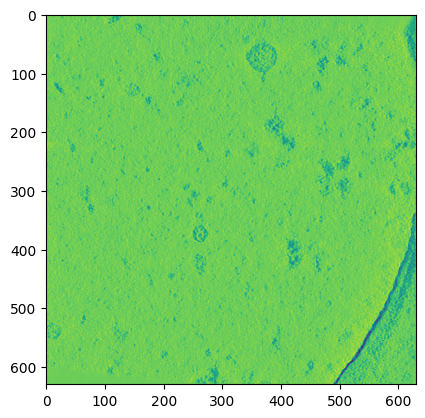

In [150]:
plt.imshow(tomograms_train[0]['tomogram'][90])
plt.show()

In [151]:
def get_label_locations(run_name,voxel_spacing = 10):
    picks_folder = copick_root_train.config.overlay_root + f'/ExperimentRuns/{run_name}/Picks'
    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            picks[json_file[:-5]] = np.array([
                [point['location']['x'] / voxel_spacing,
                 point['location']['y'] / voxel_spacing,
                 point['location']['z'] / voxel_spacing]
                for point in pick_data['points']
            ])
    return picks

rows=[]
for run in training_run_names:
    label_data = get_label_locations(run)
    for particle,locations in label_data.items():
        radius = [particle_obj.radius for particle_obj in copick_root_train.config.pickable_objects if particle_obj.name == particle][0]/10
        for location in locations:
            rows.append({'run':run,'particle':particle,'x':location[0],'y':location[1],'z':location[2],'radius':radius})
            
particle_locations_df = pd.DataFrame(rows)
particle_locations_df.sample(5)

,run,particle,x,y,z,radius
1213,TS_99_9,apo-ferritin,118.9237,488.2468,46.4122,6.0
1067,TS_99_9,ribosome,288.3189,538.2516,113.3506,15.0
927,TS_86_3,beta-galactosidase,130.4049,296.4441,118.0928,9.0
41,TS_5_4,virus-like-particle,343.5851,617.7824,101.6473,13.5
281,TS_69_2,thyroglobulin,261.8947,36.9774,74.9173,13.0


In [350]:
# Prepare a batch from all tomograms
batch = []
for tomogram in tomograms_train:
    tomogram_np = np.array(tomogram['tomogram'])  # Load tomogram
    normalized = (tomogram_np - tomogram_np.min()) / (tomogram_np.max() - tomogram_np.min())  # Normalize tomogram
    normalized = normalized[..., np.newaxis]  # Add channel dimension
    batch.append(normalized)

# Convert to a single NumPy array
batch = np.array(batch)  # Shape: (batch_size, 184, 630, 630, 1)
print(batch.shape)

(7, 184, 630, 630, 1)


In [487]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from numba import njit, prange

@njit(parallel=True)
def add_gaussian_to_heatmap_max(heatmap, z, y, x, kernel, half_size, depth, height, width):
    """
    Adds a Gaussian kernel to the heatmap at the specified (z, y, x) location using maximum.
    
    Args:
        heatmap (np.ndarray): 3D heatmap array.
        z (int): Depth index.
        y (int): Height index.
        x (int): Width index.
        kernel (np.ndarray): Precomputed Gaussian kernel.
        half_size (int): Half size of the kernel.
        depth (int): Depth of the tomogram.
        height (int): Height of the tomogram.
        width (int): Width of the tomogram.
    """
    for i in prange(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            for k in range(kernel.shape[2]):
                zi = z + i - half_size
                yi = y + j - half_size
                xi = x + k - half_size
                if 0 <= zi < depth and 0 <= yi < height and 0 <= xi < width:
                    if kernel[i, j, k] > heatmap[zi, yi, xi]:
                        heatmap[zi, yi, xi] = kernel[i, j, k]

def generate_heatmaps_optimized_max(df, tomogram_shape, particle_types):
    """
    Optimized function to generate 3D heatmaps for particle locations with maximum Gaussian spread.
    
    Args:
        df (pd.DataFrame): DataFrame with columns ['x', 'y', 'z', 'radius', 'particle'].
        tomogram_shape (tuple): Shape of the tomogram (depth, height, width).
        particle_types (list): List of unique particle types (classes).
    
    Returns:
        np.ndarray: 4D array of shape (depth, height, width, num_classes) with heatmaps.
    """
    depth, height, width = tomogram_shape
    num_classes = len(particle_types)
    heatmaps = np.zeros((depth, height, width, num_classes), dtype=np.float32)

    # Map particle types to channels
    particle_to_channel = {particle: i for i, particle in enumerate(particle_types)}

    # Group by 'particle' and 'radius'
    grouped = df.groupby(['particle', 'radius'])

    # Precompute Gaussian kernels for each group with adjusted sigma
    kernels = {}
    for (particle, radius), group in grouped:
        # Adjust sigma to ensure rapid decay within radius
        sigma = radius  # Consider setting to radius / 3 for faster decay
        if sigma == 0:
            # Handle cases where radius is zero to avoid division by zero
            kernel = np.zeros((1, 1, 1), dtype=np.float32)
            kernel[0, 0, 0] = 1.0
            kernels[(particle, radius)] = (kernel, 0)
            continue

        # Define the size of the kernel; typically 6*sigma to capture the Gaussian effectively
        kernel_size = int(6 * sigma) + 1  # Ensure kernel size is odd
        half_size = kernel_size // 2
        x = np.arange(-half_size, half_size + 1)
        y = np.arange(-half_size, half_size + 1)
        z_axis = np.arange(-half_size, half_size + 1)
        zz, yy, xx = np.meshgrid(z_axis, y, x, indexing='ij')
        kernel = np.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2))
        kernel /= kernel.max()  # Normalize the kernel peak to 1
        kernels[(particle, radius)] = (kernel.astype(np.float32), half_size)

    # Iterate over groups and add Gaussian kernels to the heatmaps
    for (particle, radius), (kernel, half_size) in tqdm(kernels.items(), desc="Generating Heatmaps"):
        channel = particle_to_channel[particle]
        # Extract all particles in the current group
        mask = (df['particle'] == particle) & (df['radius'] == radius)
        particles = df[mask][['z', 'y', 'x']].to_numpy().astype(np.int32)  # Order: z, y, x

        # Add Gaussian kernels to the heatmap using maximum
        for z, y, x in particles:
            add_gaussian_to_heatmap_max(heatmaps[..., channel], z, y, x, kernel, half_size, depth, height, width)

    return heatmaps

import time

# Assuming 'particle_locations_df' is your DataFrame
particle_types = particle_locations_df['particle'].unique()
tomogram_shape = (180, 630,630)  # Example tomogram shape

start_time = time.time()
heatmaps = generate_heatmaps_optimized_max(particle_locations_df, tomogram_shape, particle_types)
end_time = time.time()

print(f"Heatmaps generated in {end_time - start_time:.2f} seconds")
print(heatmaps.shape)  # Output: (180, 630, 630, num_classes)


Generating Heatmaps: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

Heatmaps generated in 3.33 seconds
(180, 630, 630, 6)


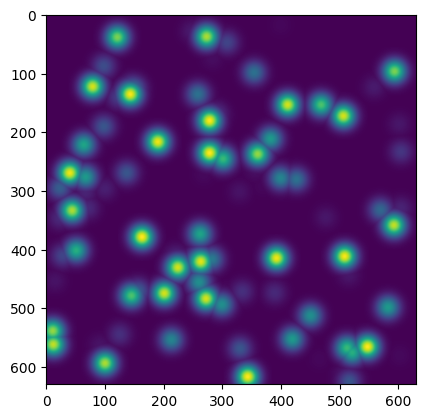

In [488]:
plt.imshow(heatmaps[100,:,:,1])

In [455]:
filtered = particle_locations_df[abs(particle_locations_df['z']-90)<particle_locations_df['radius']]

filtered

,run,particle,x,y,z,radius
2,TS_5_4,ribosome,471.5436,82.5374,80.2166,15.0
3,TS_5_4,ribosome,500.3275,78.2745,80.2480,15.0
10,TS_5_4,ribosome,421.7488,419.2518,94.1839,15.0
13,TS_5_4,ribosome,409.1497,215.9453,87.4047,15.0
15,TS_5_4,ribosome,382.2144,188.3156,100.0826,15.0
...,...,...,...,...,...,...
1263,TS_99_9,thyroglobulin,228.0316,338.0752,79.1189,13.0
1264,TS_99_9,thyroglobulin,279.0000,394.5000,79.0000,13.0
1265,TS_99_9,thyroglobulin,111.0308,573.4615,86.2154,13.0
1266,TS_99_9,thyroglobulin,314.8098,323.4683,95.2634,13.0


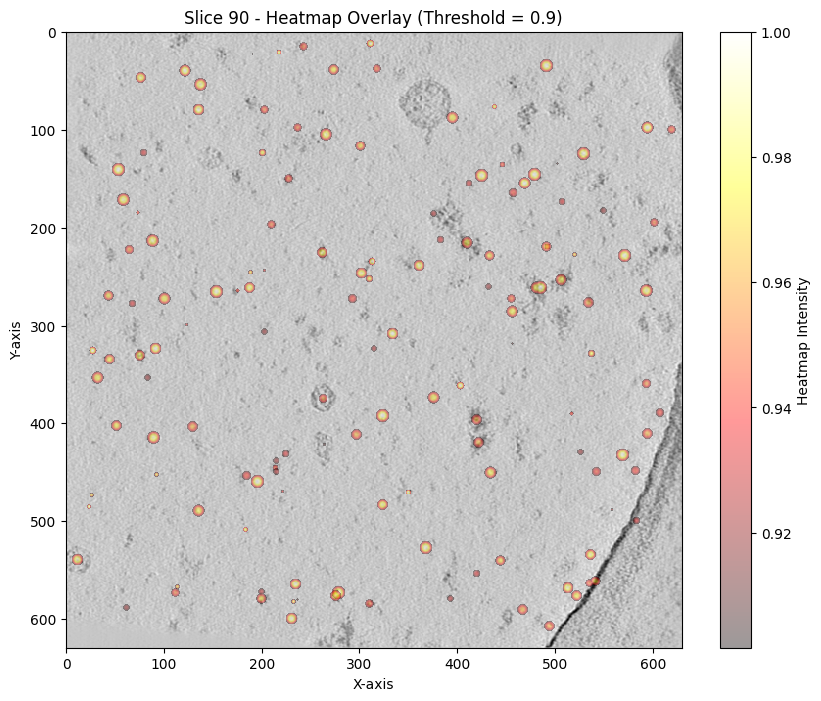

In [492]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
val = 90  # Slice index (depth)
threshold = 0.9  # Intensity threshold for transparency

# Extract the tomogram slice and heatmap slices
tomogram_slice = tomograms_train[0]['tomogram'][val]

# Plot tomogram with heatmap overlay
plt.figure(figsize=(10, 8))
plt.imshow(tomogram_slice, cmap='gray', interpolation='nearest')

for channel in range(heatmaps.shape[3]):
    heatmap_slice = heatmaps[val, :, :, channel]
    
    # Create a masked array for the heatmap
    masked_heatmap = np.ma.masked_where(heatmap_slice < threshold, heatmap_slice)
    
    plt.imshow(masked_heatmap, cmap='hot', alpha=0.4, interpolation='nearest')  # Overlay only where heatmap > threshold
# 
# filtered = particle_locations_df[abs(particle_locations_df['z']-90)<particle_locations_df['radius']/6]
# plt.scatter([record['x'] for idx,record in filtered.iterrows()],[record['y'] for idx,record in filtered.iterrows()])

plt.colorbar(label="Heatmap Intensity")  # Add a colorbar
plt.title(f"Slice {val} - Heatmap Overlay (Threshold = {threshold})")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


/var/folders/dq/6g5fch396qb663c0xjt8xsxr0000gp/T/ipykernel_57555/2863506352.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(particle_types))  # Use 'tab10' for up to 10 distinct colors
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5529412].


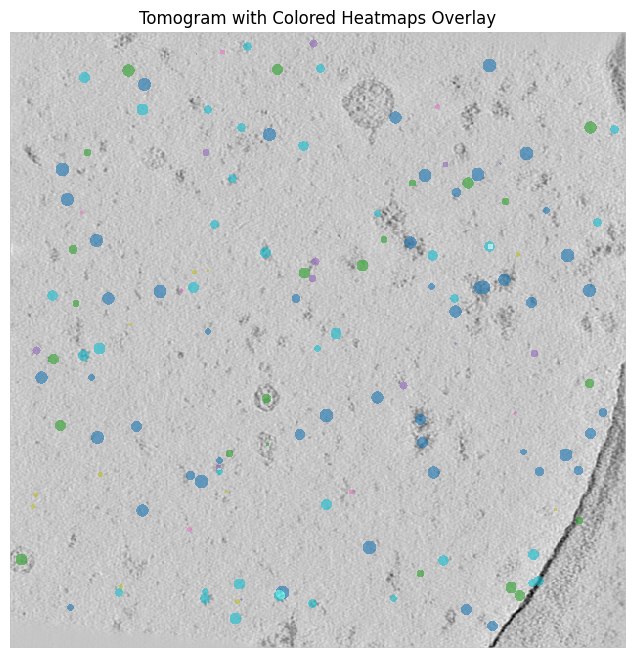

In [577]:
import numpy as np

def overlay_colored_heatmaps(tomogram_slice, heatmaps, particle_types, threshold=0.3):
    """
    Overlay a tomogram slice with colored heatmaps, assigning distinct colors to each particle type.

    Args:
        tomogram_slice (np.ndarray): 2D slice of the tomogram (grayscale).
        heatmaps (np.ndarray): 3D heatmap array of shape (height, width, num_classes).
        particle_types (list): List of particle types corresponding to heatmap channels.
        threshold (float): Intensity threshold for heatmap visibility.

    Returns:
        None: Displays the overlay plot.
    """
    # Normalize tomogram slice to [0, 1]
    tomogram_normalized = (tomogram_slice - tomogram_slice.min()) / (tomogram_slice.max() - tomogram_slice.min())
    tomogram_rgb = np.stack([tomogram_normalized] * 3, axis=-1)  # Convert grayscale to RGB

    # Generate distinct colors for each particle type
    cmap = plt.cm.get_cmap('tab10', len(particle_types))  # Use 'tab10' for up to 10 distinct colors
    particle_colors = [cmap(i)[:3] for i in range(len(particle_types))]  # Extract RGB values

    # Initialize an RGB array for the heatmap overlay
    overlay = np.zeros_like(tomogram_rgb, dtype=np.float32)
    plt.figure(figsize=(10, 8))
    plt.imshow(tomogram_rgb, interpolation='nearest')
    # Add each particle type's heatmap as a colored overlay
    for i, particle_color in enumerate(particle_colors):
        heatmap_slice = heatmaps[..., i]  # Extract the heatmap for the current particle type
        alpha_mask = heatmap_slice > threshold  # Mask to display only significant heatmap values
        for c in range(3):
            overlay[...,c] += particle_color[c] * alpha_mask

    output=np.zeros_like(overlay)
    for x_idx,x in enumerate(overlay):
        for y_idx,y in enumerate(x):
            if not y.all(0):
                output[x_idx,y_idx]=tomogram_rgb[x_idx,y_idx]
            else:
                output[x_idx,y_idx]=overlay[x_idx,y_idx]
    plt.imshow(output, cmap='hot', alpha=0.6, interpolation='nearest')
    # Plot the combined image
    
    
    plt.axis('off')
    plt.title('Tomogram with Colored Heatmaps Overlay')

    plt.show()

# Parameters
slice_index = 90  # Choose the tomogram slice index
threshold = 0.9# Set the intensity threshold for transparency

# Extract the tomogram slice and heatmap slices
tomogram_slice = tomograms_train[0]['tomogram'][slice_index]

# Overlay the heatmaps with distinct colors
overlay_colored_heatmaps(tomogram_slice, heatmaps[slice_index], particle_types, threshold=threshold)


In [578]:
from keras import layers,models


def build_3d_cnn(input_shape=(180, 630, 630, 1), num_classes=3):

    model = models.Sequential()

    model.add(layers.Conv3D(16,kernel_size=(3,3,3),activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(layers.Conv3D(32,kernel_size=(3,3,3),activation='relu',padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(layers.Conv3D(num_classes,kernel_size=(3,3,3),activation='sigmoid',padding='same'))
    
    return model

input_shape = (180,630,630,1)
num_classes = 3
model = build_3d_cnn(input_shape=input_shape, num_classes=num_classes)
model.summary()

/Users/jake.brannigan/Documents/Kaggle/CryoET/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 180, 630, 630,  │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 90, 315, 315,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 90, 315, 315,   │        13,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 45, 157, 157,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 45, 157, 157,   │         2,595 │
│                                 │ 3)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,899 (66.01 KB)

 Trainable params: 16,899 (66.01 KB)

 Non-trainable params: 0 (0.00 B)

In [580]:
from keras.api.losses import BinaryCrossentropy

loss = BinaryCrossentropy()
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])

In [591]:
batch.shape # (7, 184, 630, 630, 1)

(7, 184, 630, 630, 1)

In [ ]:
steps_per_epoch = len(scans) // batch_size
model.fit(gen, steps_per_epoch=steps_per_epoch, epochs=10)